# Estimate Poverty Index (PI)

- `Resampling`. Resmaple the resolution of night lights (750m) to the resolution of LandScan (1Km)
- `Poverty Index`. Divide the LandScan population count by the average visible band digital number from the night lights. High poverty index values occur in areas with high LandScan population count and dim (or no) lighting as detected by the VIIRS sensor
- `Normalized poverty index (NPI)`. The sum of the poverty index values are extracted for each area(LA). This sum is then divided by the total population count and multiplied by 100 to form a `normalized poverty index (NPI)`
    - NPI is calculated for each Local Authority using zonal statistics and the LAD administrative boundaries.

In [1]:
import os
import glob
import re

import rasterio
from rasterio.windows import Window
from rasterio.plot import show
from rasterstats import zonal_stats
import numpy as np
import scipy
from scipy.stats import *
import pandas as pd
import geopandas as gpd

import matplotlib.pylab as plt
import seaborn as sns

import warnings
warnings.simplefilter('ignore', np.RankWarning)

In [2]:
DATA_PATH = '/home/io/ASTROSAT/code/night-lights/data/years'


In [10]:
RGB_nightlights_path = os.path.join(DATA_PATH,'night_lights_RGB_GB.tif')

with rasterio.open(RGB_nightlights_path, 'r') as src:
    band_2012 = src.read(1)
    band_2013 = src.read(2)
    band_2014 = src.read(3)
    band_2015 = src.read(4)
    band_2016 = src.read(5)
    band_2017 = src.read(6)

### Take average of night lights time series of the UK

In [11]:
mean_2012 = np.average(band_2012)
mean_2013 = np.average(band_2013)
mean_2014 = np.average(band_2014)
mean_2015 = np.average(band_2015)
mean_2016 = np.average(band_2016)
mean_2017 = np.average(band_2017)

### Plot Average values of night lights

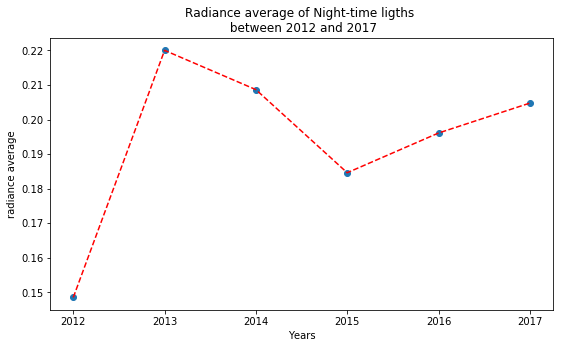

In [33]:
fig, ax = plt.subplots(1, figsize=(9,5))

dates_list = [2012,2013,2014,2015,2016,2017]
avg_values = [mean_2012,mean_2013,mean_2014,mean_2015,mean_2016,mean_2017]

ax.plot(dates_list, avg_values, 'o')
ax.plot(dates_list, avg_values, '--r',)
ax.set_title('Radiance average of Night-time ligths \n between 2012 and 2017')
ax.set_xlabel('Years')
ax.set_ylabel('radiance average');

### Resample cell size of night lights data to the resolution of LandScan

In [10]:
!gdalwarp -tr 0.00833 0.00833 -of GTiff data/years/night_lights_RGB_GB.tif data/years/night_lights_RGB_GB_resampled.tif

Creating output file that is 1856P x 1400L.
Processing input file data/years/night_lights_RGB_GB.tif.
0...10...20...30...40...50...60...70...80...90...100 - done.


In [3]:
# Subset the raster for plotting purposes
landscan_window = (200, 1400),(1000, 1900)
nightlights_window = (300, 1600),(1000, 1800)

### Load the rasampled nighttime-lights and population data (LandScan) and display them

In [9]:
data_path_LandScan = os.path.join(DATA_PATH,'LandScan_UK.tif')
data_path_nightLights = os.path.join(DATA_PATH,'DMSP_stable_lights_UK.tif')
#data_path_nightLights = os.path.join(DATA_PATH,'night_lights_RGB_GB_resampled.tif')

with rasterio.open(data_path_LandScan, 'r') as src_landscan:
    landscan = src_landscan.read(1)
    #landscan_window = src_landscan.read(1, window=landscan_window)
    landscan_transform = src_landscan.transform

with rasterio.open(data_path_nightLights, 'r') as src_nightlights:
    nightlights = src_nightlights.read(1, masked=True) # PUT IT BACK TO 6
    #nightlights_window = src_nightlights.read(6, window=nightlights_window)
    nightlights_transform = src_nightlights.transform

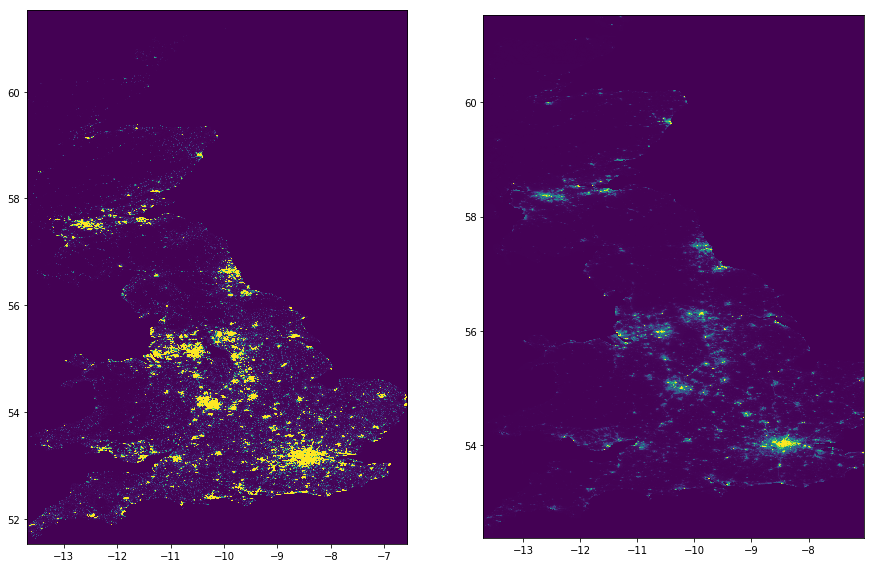

In [6]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 15))

show(landscan_window,
     ax=ax1,
     transform=landscan_transform,
     vmin=0,
     vmax=1000)

show(nightlights_window,
     ax=ax2,
     transform=nightlights_transform,
     vmin=0,
     vmax=35)

### Poverty Index (PI) and Normalized Poverty Index (NPI)
- Firstly, we devide the population count with the night lights to get a general overview of the poverty index for UK 
- Use Local Authority boundaries to estimate the poverty for each one of them

In [4]:
# Shape of two rasters is different. LandScan has shape of 1400 x 1855 while nightlights has shape of 1400 x 1855. In order to make both shapes compatile,
# we need to add an extra column on LandScan raster
landscan = np.c_[(landscan, np.zeros(landscan.shape[0]))]

In [10]:
# Large negative values are assigned for no data to the landscan raster. Thse negative values are added to the final raster when performing zonal statistics.
# We need to re-assign those values to zero, so that we avoid negative values appearing to final raster
landscan[landscan==-2147483647] = 0


### Poverty Index calculation in each grid cell

In [11]:
# Areas with radiance between 0.001 and 0.4 do not have any population
#nightlights_rendered = np.where(nightlights==0.0, landscan, nightlights)

PI = landscan / nightlights
PI_index = np.where(PI==0, landscan, PI)

#PI[np.isnan(PI)] = -999
#PI[np.isinf(PI)] = -999


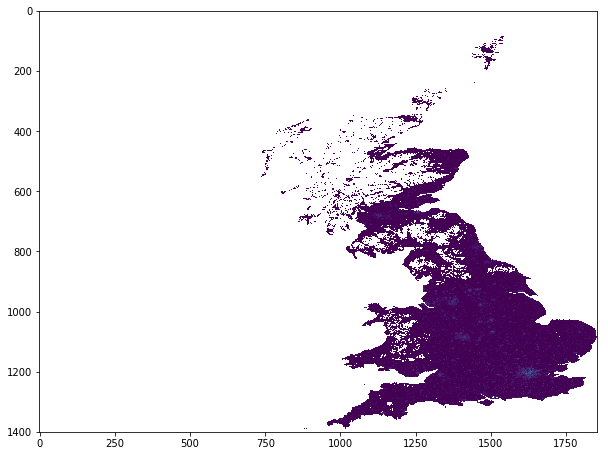

In [32]:
fig, ax = plt.subplots(1, figsize=(10, 10))

plt.imshow(PI, vmin=0, vmax=500)

### Write the raster

In [139]:
profile = src_nightlights.profile
profile.update(dtype=PI.dtype, 
               count=1, 
               compress='lzw')
               

with rasterio.open(os.path.join(DATA_PATH + '/PI_VIIRS.tif'), "w", **profile) as dst:
        dst.write(PI.astype(rasterio.float64), 1)

### Normalized poverty Index calculation for each local authority

In [12]:
lad_path = os.path.join(DATA_PATH,'lad','Local_Authority_Districts_2016_WGS84.shp')

# load the loca authorities
lad = gpd.read_file(lad_path)
lad = lad.rename(columns={'lad16cd': 'LAD code'})

### Calculate the sum of poverty index and population count for each local authority
- When calculating zonal statistics, rasters with large negative values (e,g landscan) should be set to zero. In order for this to happen, when loading the raster file with rasterio, we should not specify masked= True

In [13]:
def mysum(x):
    return np.nansum(x)

In [14]:
stats_popcount = zonal_stats(lad_path, 
                             landscan,
                             affine=landscan_transform,
                             stats=['count','min', 'max','mean', 'sum']
                             )

stats_nightlights = zonal_stats(lad_path, 
                                nightlights,
                                affine=nightlights_transform,
                                stats=['count','min', 'max','mean', 'sum']
                                )

stats_PI = zonal_stats(lad_path, 
                       PI_index,
                       affine=landscan_transform,
                       stats=['count','min', 'max','mean', 'sum'],
                       add_stats={'mysum':mysum}
                       )


/home/io/miniconda2/envs/geopython/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/home/io/miniconda2/envs/geopython/lib/python3.6/site-packages/rasterstats/main.py:165: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  np.issubdtype(fsrc.array.dtype, float)


In [15]:
landscan_sum = [p['sum'] for p in stats_popcount]
PI_sum = [pi['mysum'] for pi in stats_PI]


In [16]:
lad['landscan_sum'] = landscan_sum
lad['PI_sum'] = PI_sum

lad['NPI'] =  (lad['PI_sum'] / lad['landscan_sum']) * 100

In [17]:
lad_England = lad.loc[lad['LAD code'].str.contains('^E[0-9]{8}$')]

In [18]:
lad_England.head()

,objectid,LAD code,lad16nm,lad16nmw,bng_e,bng_n,long,lat,st_areasha,st_lengths,geometry,landscan_sum,PI_sum,NPI
0,1,E06000001,Hartlepool,None,447157,531476,-1.27023,54.676159,9.359786e+07,69382.685924,(POLYGON ((-1.270251753363295 54.7271686841496...,93093.0,2068.668260,2.222152
1,2,E06000002,Middlesbrough,None,451141,516887,-1.21099,54.544670,5.387900e+07,42085.584812,(POLYGON ((-1.230028686242537 54.5841083796549...,141440.0,2331.173628,1.648171
2,3,E06000003,Redcar and Cleveland,None,464359,519597,-1.00611,54.567520,2.448388e+08,96189.660709,(POLYGON ((-1.137180612046189 54.6469456735212...,135685.0,2678.080057,1.973748
3,4,E06000004,Stockton-on-Tees,None,444937,518183,-1.30669,54.556911,2.049366e+08,115439.477112,(POLYGON ((-1.31775721744014 54.64525078071659...,191917.0,3289.060035,1.713793
4,10,E06000010,"Kingston upon Hull, City of",None,511894,431716,-0.30380,53.769791,7.145577e+07,63330.240277,(POLYGON ((-0.3161343125795458 53.813270163665...,262421.0,6995.324899,2.665688


In [14]:
lad_England.to_file(os.path.join(DATA_PATH,'shp_testing','DMPS_NPI.shp'),driver='ESRI Shapefile')

### Perform regression analysis between Normalized Poverty Index and Multiple Deprivation Index
1. call the funtion `get_deprivation_data`. This function, internally, groups deprivation data into `LAD code`  so that it matches the `lad` dataframe
2. From the `lad` dataframe, select only `lad name == england` so that number of rows matches the rows of the `get_deprivation_data` dataframe
3. Join `lad` dataframe with `get_deprivation_data` dataframe. Before doing that, we first need to:
    - Set `LAD code` as index for`lad` dataframe. `get_deprivation_data` dataframe is already in index
4. (Optionally), we can attach the results from join to LAD geo-dataframe and export it as shapefile

In [34]:
# change the working directory in order to import the python modules from uk-stats
os.chdir('/home/io/ASTROSAT/code/uk-stats')

In [35]:
import ukstats.geometries as gm
import ukstats.attributes as at
from ukstats import geometries
from ukstats.utils import select_and_rename_columns
from ukstats.constants import ATTRIBUTES_DATA_PATH

In [36]:
def get_deprivation_data(country='england'):

    input_path = glob.glob(
        os.path.join(ATTRIBUTES_DATA_PATH, f'deprivation_lsoa_{country}.*'))[0]

    if country == 'england':
        df = pd.read_excel(input_path, sheet_name=1)
        columns = {'LSOA code (2011)': 'LSOA code',
                   'Local Authority District code (2013)' : 'LAD code',
                   'Index of Multiple Deprivation (IMD) Decile (where 1 is most deprived 10% of LSOAs)': 'IMD: Overall decile',
                   'Income Decile (where 1 is most deprived 10% of LSOAs)': 'IMD: Income decile',
                   'Employment Decile (where 1 is most deprived 10% of LSOAs)': 'IMD: Employment decile',
                   'Education, Skills and Training Decile (where 1 is most deprived 10% of LSOAs)': 'IMD: Education decile',
                   'Health Deprivation and Disability Decile (where 1 is most deprived 10% of LSOAs)': 'IMD: Health decile',
                   'Crime Decile (where 1 is most deprived 10% of LSOAs)': 'IMD: Crime decile',
                   'Barriers to Housing and Services Decile (where 1 is most deprived 10% of LSOAs)': 'IMD: Barriers to housing and services decile',
                   'Living Environment Decile (where 1 is most deprived 10% of LSOAs)': 'IMD: Living environment decile'}
        df = select_and_rename_columns(df, columns, 'LAD code')
        df_grouped = df.groupby('LAD code')
        df_grouped_mean = df_grouped.mean()
        
    return df_grouped_mean


In [37]:
deprivation = get_deprivation_data()

### Perform join

In [20]:
lad_E0 = lad.loc[lad['LAD code'].str.contains('^E[0-9]{8}$')]
lad_indexed = lad_E0.set_index('LAD code')
df = lad_indexed.join(deprivation)
df_reset_index = df.reset_index()

### Select appropriate attributes

In [21]:
attributes_list = ['LAD code','NPI','IMD: Overall decile','IMD: Income decile','IMD: Employment decile','IMD: Education decile','IMD: Health decile','IMD: Crime decile','IMD: Barriers to housing and services decile','IMD: Living environment decile']
# select the necessary attributes
df = df_reset_index[attributes_list]
df = df.set_index('LAD code')

### Attach attributes to LAD shapefile

In [49]:
lad_polygons = geometries.get_lad_polygons()

In [120]:
lad_data = lad_polygons.join(df)

### Regression analysis

In [26]:
df_overall = df.loc[df['NPI']<= 10] 


### Regression of the whole datasets

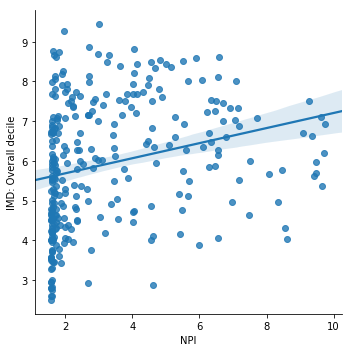

In [27]:
sns.lmplot(x='NPI',y='IMD: Overall decile',data=df_overall,fit_reg=True, order=1) ;

### Regression only with the less deprived areas

In [30]:
df_best = df.loc[df['NPI']<= 10] 

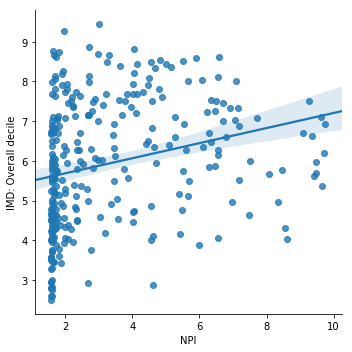

In [31]:
sns.lmplot(x='NPI',y='IMD: Overall decile',data=df_best,fit_reg=True, order=1) ;

### Regression only with the most deprived areas

In [32]:
df_worst = (df['NPI']>= 8) & (df['NPI']<= 20)
df_worst = df[df_worst]

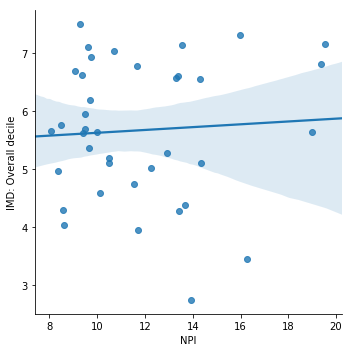

In [33]:
sns.lmplot(x='NPI',y='IMD: Overall decile',data=df_worst,fit_reg=True, order=1) ;

### outliers

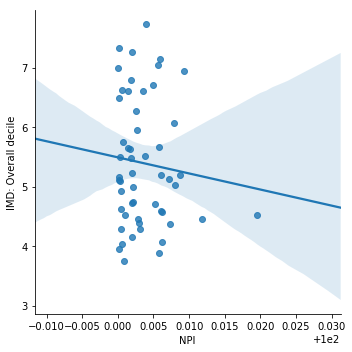

In [64]:
sns.lmplot(x='NPI',y='IMD: Overall decile',data=df_worst,fit_reg=True, order=1) ;

1.0
-0.005399106925547934
-0.0028217497015504073
-0.006780154546849611
-0.007462968706684022
-0.0077226786973837915
0.006088657413723401
0.003966865277038602
-0.004850865042505139


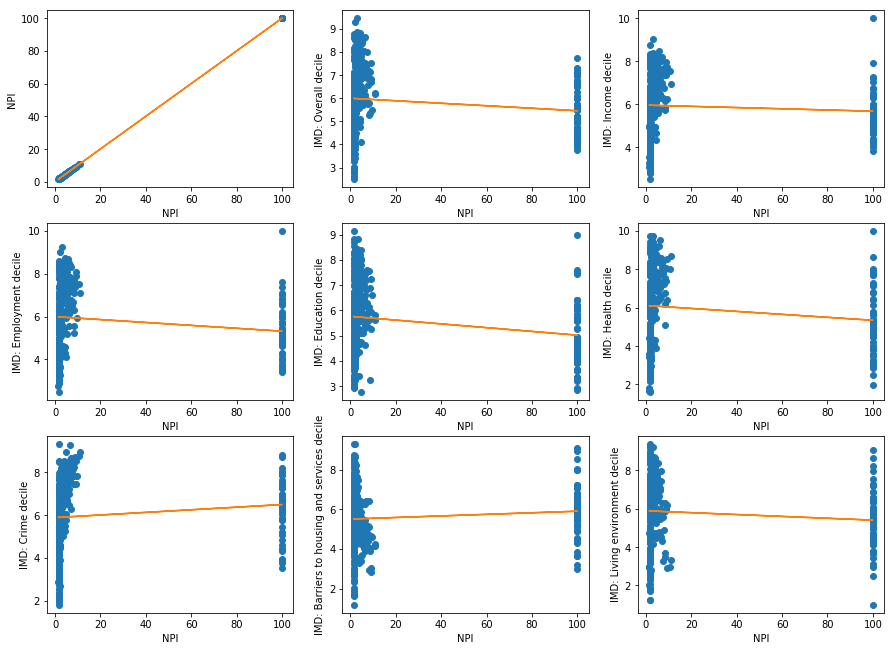

In [34]:
fig = plt.figure(figsize=(15, 15))
for i, (colname, col) in enumerate(df.iteritems()):
    ax = fig.add_subplot(4, 3, i+1)
    poly_fit = scipy.polyfit(df['NPI'], df[colname] , 1)
    poly_val = scipy.polyval(poly_fit, df['NPI'])
    slope_VV, intercept_VV, r_value_VV, p_value_VV, std_error_VV = linregress(df['NPI'], df[colname])
    print (slope_VV)
    ax.plot(df['NPI'], df[colname], 'o')
    ax.plot(df['NPI'], poly_val)
    ax.set_xlabel('NPI')
    ax.set_ylabel(colname)

### Find nan values in the dataframe

In [22]:
gpd.isnull().values.sum()

27

In [37]:
idx, idy = np.where(df.isnull())
result = np.column_stack([df.index[idx], df.columns[idy]])

result

array([], shape=(0, 2), dtype=object)

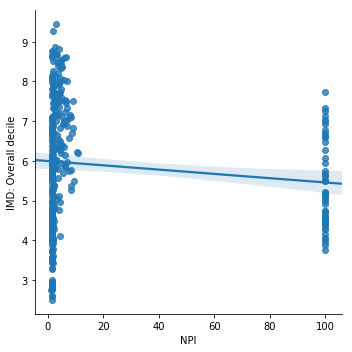

In [35]:
sns.lmplot(x='NPI',y='IMD: Overall decile',data=df,fit_reg=True, order=1) ;

## TESTING

In [3]:
import numpy.ma as ma

In [3]:
#albania
#data_path_LandScan = os.path.join(DATA_PATH,'countries_stats_testing','albania','landscan_albania.tif')
#data_path_nightLights = os.path.join(DATA_PATH,'countries_stats_testing','albania','DMSP_albania.tif')
#aruba
#data_path_LandScan = os.path.join(DATA_PATH,'countries_stats_testing','aruba','landscan_aruba.tif')
#data_path_nightLights = os.path.join(DATA_PATH,'countries_stats_testing','aruba','DMSP_aruba.tif')
#cambodia
#data_path_LandScan = os.path.join(DATA_PATH,'countries_stats_testing','cambodia','landscan_cambodia.tif')
#data_path_nightLights = os.path.join(DATA_PATH,'countries_stats_testing','cambodia','nighlights_cambodia.tif')
#uganda
#data_path_LandScan = os.path.join(DATA_PATH,'countries_stats_testing','uganda','landscan_uganda.tif')
#data_path_nightLights = os.path.join(DATA_PATH,'countries_stats_testing','uganda','nighlights_uganda.tif')
#United Kingdom
#data_path_LandScan = os.path.join(DATA_PATH,'LandScan_UK.tif')
#data_path_nightLights = os.path.join(DATA_PATH,'DMSP_stable_lights_UK.tif')
data_path_LandScan = os.path.join(DATA_PATH,'countries_stats_testing','blackpool','landscan_blackpool.tif')
data_path_nightLights = os.path.join(DATA_PATH,'countries_stats_testing','blackpool','nighlights_blackpool.tif')


with rasterio.open(data_path_LandScan, 'r') as src_landscan:
    landscan = src_landscan.read(1)
    landscan_transform = src_landscan.transform

with rasterio.open(data_path_nightLights, 'r') as src_nightlights:
    nightlights = src_nightlights.read(1,masked=True) 
    nightlights_transform = src_nightlights.transform

In [4]:
landscan[landscan==-2147483647] = 0
#landscan_msk = ma.masked_where(landscan == -2147483647, landscan)
#nightlights_msk = ma.masked_where(nightlights == 0, nightlights)

In [30]:
landscan.shape

(362, 215)

In [31]:
nightlights.shape

(362, 215)

In [80]:
landscan = np.c_[(landscan, np.zeros(landscan.shape[0]))]

## Pass population count to nightlights

In [11]:
nightlights_rendered = np.where(nightlights==0, landscan, nightlights)

In [12]:
pop_count = np.sum(landscan)

In [13]:
PI = landscan / nightlights_rendered
PI_sum = np.nansum(PI)

/home/io/miniconda2/envs/geopython/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
/home/io/miniconda2/envs/geopython/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


In [14]:
npi = (PI_sum / pop_count) * 100
npi

1.9871506927358464

## Pass population count to the PI index

In [5]:
pop_count = np.sum(landscan)

In [6]:
PI = landscan / nightlights

In [7]:
PI_index = np.where(PI==0, landscan, PI)
PI_sum = np.nansum(PI_index)

In [8]:
npi = (PI_sum / pop_count) * 100
npi

8.172493790402417

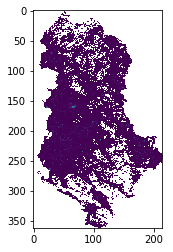

In [41]:
plt.imshow(PI)

In [43]:
profile = src_nightlights.profile
profile.update(dtype=PI.dtype, 
               count=1, 
               compress='lzw')
               

with rasterio.open(os.path.join(DATA_PATH + '/PI_testing.tif'), "w", **profile) as dst:
        dst.write(PI.astype(rasterio.float64), 1)